In [60]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from omegaconf import OmegaConf
import seaborn as sns
import pandas as pd
import sys
sys.path.append('..')
import neatplot
neatplot.set_style()
matplotlib.rcParams['text.usetex'] = True
neatplot.update_rc('font.size', 20)
%matplotlib inline

In [61]:
base_path = Path('../experiments')
baseline_path = Path('../../bac-baselines/experiments')
process_seeds = False

In [62]:
pilco_name = 'pilco_dataset_2021-12-14/09-48-04/'

In [63]:
pilco_base_path = base_path / pilco_name

In [116]:
def process_pilco_dir(path):
    info_path = path / 'info.pkl'
    cfg_path = path / '.hydra' / 'config.yaml'
    with info_path.open('rb') as f:
        info = pickle.load(f)
    risks = info['Bayes Risks'][0]
    mpc_returns = info['Eval Returns'][0]
    policy_returns = info["GT Returns"]
    policy_ndata = info["GT Return ndata"]
    # policy_ndata = info[]
    cfg = OmegaConf.load(cfg_path)
    ndata = cfg.num_init_data
    return mpc_returns, risks, ndata, np.squeeze(np.array(policy_returns[1:])), policy_ndata[0]

In [117]:
data = {}

In [118]:
for sd in pilco_base_path.iterdir():
    if not sd.name.startswith('seed'):
        continue
    mpc_returns, pilco_risks, ndata, policy_returns, policy_ndata = process_pilco_dir(sd)
    data[ndata] = (mpc_returns, pilco_risks, policy_returns, policy_ndata)

ValueError: too many values to unpack (expected 2)

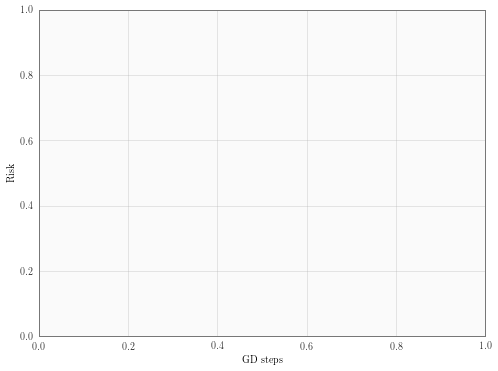

In [119]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("GD steps")
ax.set_ylabel("Risk")
for ndata, (mpc_returns, pilco_risks) in data.items():
    line = ax.plot(pilco_risks, label=f"{ndata} datapoints")[0]
    ax.axhline(-np.mean(mpc_returns), linestyle='--', color=line.get_color())
ax.legend()
ax.set_title("PILCO on Cartpole with random data")

Text(0.5, 1.0, 'PILCO on Cartpole with random data (in environment)')

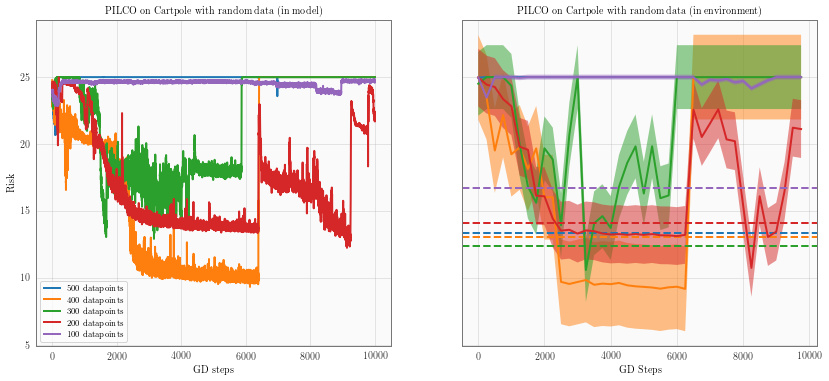

In [129]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ax1.set_xlabel("GD steps")
ax2.set_xlabel("GD Steps")
ax1.set_ylabel("Risk")
for ndata, (mpc_returns, pilco_risks, policy_returns, policy_ndata) in data.items():
    line = ax1.plot(pilco_risks, label=f"{ndata} datapoints")[0]
    ax2.axhline(-np.mean(mpc_returns), linestyle='--', color=line.get_color())
    nsamps = policy_returns.shape[1]

    means = -np.mean(policy_returns, axis=1)
    stderr = np.std(policy_returns) / np.sqrt(nsamps)
    ax2.plot(policy_ndata, means, label=f"{ndata} datapoints")
    ax2.fill_between(policy_ndata, means - stderr, means + stderr, alpha=0.5)

ax1.legend()
ax1.set_title("PILCO on Cartpole with random data (in model)")
ax2.set_title("PILCO on Cartpole with random data (in environment)")